In [11]:
SW = 0.5
VW = 0.5
SN = 100
NI = 200

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from matplotlib.patches import Polygon
from typing import List, Tuple

class GraphWithPolygons:
    def __init__(self, edges: List[Tuple[str, str]], size_factor: float = 1.0):
        self.graph = nx.Graph()
        self.graph.add_edges_from(edges)
        self.size_factor = size_factor
        self.radii = self._initialize_radii()
        self.node_mapping = {node: idx for idx, node in enumerate(self.graph.nodes)}

    def _initialize_radii(self) -> torch.Tensor:
        label_lengths = torch.tensor([len(node) for node in self.graph.nodes])
        radii = self.size_factor * (0.02 * label_lengths + 0.1)
        return radii

def create_polygon(x: float, y: float, radius: float, n_sides: int) -> Polygon:
    theta = np.linspace(0, 2 * np.pi, n_sides, endpoint=False)
    vertices = np.vstack((np.cos(theta), np.sin(theta))).T * radius + np.array([x, y])
    return Polygon(vertices, closed=True, color='lightblue', ec='black')

def generate_random_points(num_points: int) -> torch.Tensor:
    return torch.rand(size=(num_points, 2), requires_grad=True)

def draw_graph_with_polygons(graph: GraphWithPolygons, points: torch.Tensor, n_sides: int, title: str):
    fig, ax = plt.subplots()
    pos = {node: (points[i][0].item(), points[i][1].item()) for i, node in enumerate(graph.graph.nodes())}

    for node, (x, y) in pos.items():
        radius = graph.radii[list(graph.graph.nodes()).index(node)].item()  # Ensure radius is a float
        polygon = create_polygon(x, y, radius, n_sides)
        ax.add_patch(polygon)
        ax.text(x, y, node, ha='center', va='center', fontsize=12)

    for edge in graph.graph.edges():
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        ax.plot([x1, x2], [y1, y2], color='gray')

    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()

def compute_stress(pos: torch.Tensor, graph: nx.Graph, node_mapping: dict) -> torch.Tensor:
    n = pos.shape[0]
    stress = 0
    for i in range(n):
        for j in range(i + 1, n):
            d_ij = torch.dist(pos[i], pos[j])
            node_i = list(node_mapping.keys())[i]
            node_j = list(node_mapping.keys())[j]
            graph_dist = nx.shortest_path_length(graph, source=node_i, target=node_j)
            stress += (d_ij - graph_dist) ** 2
    return stress

def node_overlap_loss(pos: torch.Tensor, radii: torch.Tensor, sample_size=None, sample=None) -> torch.Tensor:
    pairwise_distance = nn.PairwiseDistance()
    relu = nn.ReLU()

    n = pos.shape[0]
    if sample is None:
        if sample_size is None or sample_size == 'full':
            indices = torch.arange(n)
        else:
            indices = torch.randperm(n)[:sample_size]
        sample = torch.cartesian_prod(indices, indices)

    a = pos[sample[:, 0]]
    b = pos[sample[:, 1]]
    radii_a = radii[sample[:, 0]]
    radii_b = radii[sample[:, 1]]
    pdist = pairwise_distance(a, b)

    normalized_dist = pdist / (radii_a + radii_b)
    loss = relu(1 - normalized_dist).pow(2).mean()

    return loss

def combined_loss(pos: torch.Tensor, graph: nx.Graph, radii: torch.Tensor, node_mapping: dict, stress_weight: float, overlap_weight: float) -> torch.Tensor:
    stress = compute_stress(pos, graph, node_mapping)
    overlap = node_overlap_loss(pos, radii)
    return stress_weight * stress + overlap_weight * overlap

def optimize_graph_layout(graph: GraphWithPolygons, points: torch.Tensor, num_iterations: int = NI, lr: float = 0.01, stress_weight: float = SW, overlap_weight: float = VW):
    optimizer = torch.optim.SGD([points], lr=lr)

    for i in range(num_iterations):
        optimizer.zero_grad()
        loss = combined_loss(points, graph.graph, graph.radii, graph.node_mapping, stress_weight, overlap_weight)
        loss.backward()
        optimizer.step()

        if i % 1 == 0:
            print(f"Iteration {i}: Loss = {loss.item()}")

    return points




In [13]:
# Clone the GitHub repository
!git clone https://github.com/abureyanahmed/multi_level_tree.git


fatal: destination path 'multi_level_tree' already exists and is not an empty directory.


In [14]:
# Define the function to read edges from a file
def read_edges_from_file(file_path: str) -> List[Tuple[str, str]]:
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(" -- ")
            edge = (parts[0].strip('"'), parts[1].strip('"'))
            edges.append(edge)
    return edges

# File path within the cloned repository
file_path = 'multi_level_tree/dataset/lastfm_refined/Graph_1_50.txt'

# Read the file and process the edges
edges = read_edges_from_file(file_path)
print(edges)

[('Massive Attack', 'The Dust Brothers'), ('Massive Attack', 'DJ Krush'), ('Thom Yorke', 'LCD Soundsystem'), ('Thom Yorke', 'UNKLE'), ('The Offspring', 'Bad Religion'), ('The Offspring', 'Red Hot Chili Peppers'), ('DJ Krush', 'Kruder & Dorfmeister'), ('The White Stripes', 'Red Hot Chili Peppers'), ('The White Stripes', 'Franz Ferdinand'), ('Duncan Sheik', 'The Verve Pipe'), ('Duncan Sheik', 'Josh Kelley'), ('Josh Kelley', 'Tristan Prettyman'), ('Fuel', 'The Verve Pipe'), ('Fuel', 'Lit'), ('Eric Clapton', 'Johnny Winter'), ('Keane', 'The Feeling'), ('Keane', 'Franz Ferdinand'), ('The Apples in Stereo', 'The Polyphonic Spree'), ('The Apples in Stereo', 'Neutral Milk Hotel'), ('Lit', 'The Ataris'), ('Spandau Ballet', 'Simply Red'), ('Spandau Ballet', 'Frankie Goes to Hollywood'), ('Tristan Prettyman', 'Jack Johnson'), ('Me First and the Gimme Gimmes', 'No Use for a Name'), ('Me First and the Gimme Gimmes', 'Bad Religion'), ('Alphaville', 'Falco'), ('Simply Red', 'Sting'), ('Falco', 'Frank

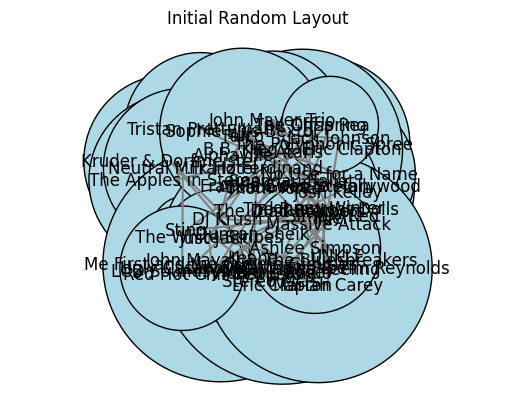

Iteration 0: Loss = 197978.015625
Iteration 1: Loss = 101399.0625
Iteration 2: Loss = 66433.90625
Iteration 3: Loss = 51082.8984375
Iteration 4: Loss = 40881.7890625
Iteration 5: Loss = 32199.75390625
Iteration 6: Loss = 25767.849609375
Iteration 7: Loss = 21047.02734375
Iteration 8: Loss = 17258.87890625
Iteration 9: Loss = 13630.068359375
Iteration 10: Loss = 10096.138671875
Iteration 11: Loss = 7097.98681640625
Iteration 12: Loss = 4991.28076171875
Iteration 13: Loss = 3605.63037109375
Iteration 14: Loss = 2687.6435546875
Iteration 15: Loss = 2058.3447265625
Iteration 16: Loss = 1611.1241455078125
Iteration 17: Loss = 1283.9097900390625
Iteration 18: Loss = 1039.179443359375
Iteration 19: Loss = 852.9791870117188
Iteration 20: Loss = 709.2845458984375
Iteration 21: Loss = 597.05322265625
Iteration 22: Loss = 508.5413818359375
Iteration 23: Loss = 438.1813049316406
Iteration 24: Loss = 381.8580627441406
Iteration 25: Loss = 336.470458984375
Iteration 26: Loss = 299.65643310546875
Ite

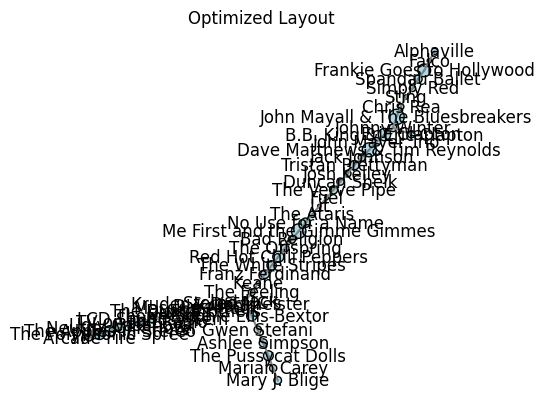

Final combined loss: 92.4042739868164


In [15]:
# Create an instance of the class
graph_with_polygons = GraphWithPolygons(edges)

# Generate random points for the graph
points = generate_random_points(len(graph_with_polygons.graph.nodes))

# Draw the initial random layout
draw_graph_with_polygons(graph_with_polygons, points, n_sides=SN, title="Initial Random Layout")

# Optimize the graph layout using combined stress and node overlap loss
optimized_points = optimize_graph_layout(graph_with_polygons, points, num_iterations=NI, lr=0.01, stress_weight=SW, overlap_weight=VW)

# Draw the optimized layout
draw_graph_with_polygons(graph_with_polygons, optimized_points, n_sides=SN, title="Optimized Layout")

# Calculate final combined loss
final_loss = combined_loss(optimized_points, graph_with_polygons.graph, graph_with_polygons.radii, graph_with_polygons.node_mapping, SW, VW)
print(f"Final combined loss: {final_loss.item()}")